## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [5]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# l1

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
    """
    Build your own model
    """

In [7]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [ 1e-4,  1e-12]

In [8]:
results = {}
"""
Set your training loop
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 317us/step - loss: 2.0400 - acc: 0.2608 - val_loss: 1.8729 - val_acc: 0.3455
Epoch 2/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.8160 - acc: 0.3646 - val_loss: 1.7705 - val_acc: 0.3891
Epoch 3/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.7262 - acc: 0.3981 - val_loss: 1.6928 - val_acc: 0.4111
Epoch 4/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.6643 - acc: 0.4205 - val_loss: 1.6384 - val_acc: 0.4267
Epoch 5/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.6155 - acc: 0.4377 - val_loss: 1.6012 - val_acc: 0.4432
Epoch 6/50
50000/50000 [==============================] - 16s 317us/step - loss: 1.5762 - acc: 0.4496 - val_loss: 1.5683 - val_acc: 0.4477
Epoch 7/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.5416 - acc: 0.4589 - val_loss: 1.

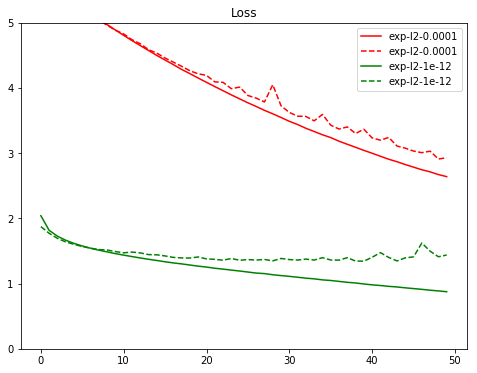

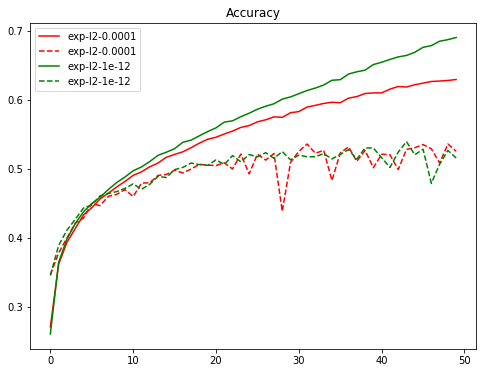

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# l1_l2

In [13]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [ 1e-4,  1e-12]

In [15]:
results = {}
"""
Set your training loop
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 360us/step - loss: 15.1306 - acc: 0.2530 - val_loss: 13.9868 - val_acc: 0.3261
Epoch 2/50
50000/50000 [==============================] - 17s 349us/step - loss: 13.0432 - acc: 0.3528 - val_loss: 12.1471 - val_acc: 0.3632
Epoch 3/50
50000/50000 [==============================] - 17s 349us/step - loss: 11.3644 - acc: 0.3754 - val_loss: 10.6110 - val_acc: 0.3852
Epoch 4/50
50000/50000 [==============================] - 17s 349us/step - loss: 9.9502 - acc: 0.3904 - val_loss: 9.3103 - val_acc: 0.4018
Epoch 5/50
50000/50000 [==============================] - 17s 348us/step - loss: 8.7481 - acc: 0.4024 - val_loss: 8.2023 - val_acc: 0.4091
Epoch 6/50
50000/50000 [==============================] - 18s 352us/step - loss: 7.7238 - acc: 0.4088 - val_loss: 7.2951 - val_acc: 0.3927
Epoch 7/50
50000/50000 [==============================] - 18s 350us/step - loss: 6.8516 - acc: 0.4146 - val_lo

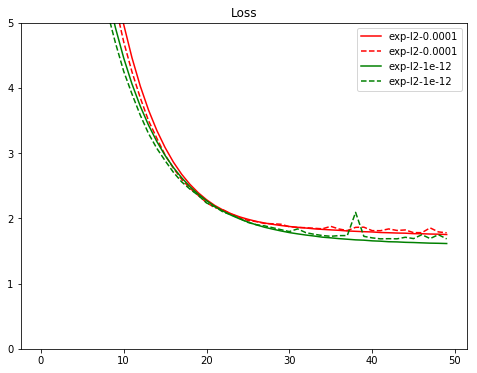

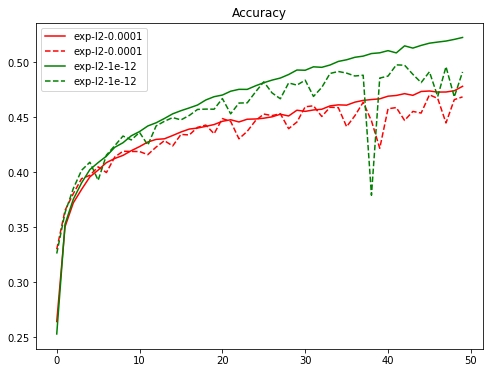

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# 看起來L1_L2的泛化能力好像比較好